# Clustering comparison

### Packages

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans, Birch
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import Birch  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

### Dataset

In [268]:

data = pd.read_csv('/Users/aameerkhan/Desktop/testdata2.csv')
data = data.drop(['customerID'], axis = 1)
X = data[['tenure', 'MonthlyCharges', 'TotalCharges']] 
y = data['Churn']

print(X)


    tenure  MonthlyCharges  TotalCharges
0       61           83.26       1800.05
1       13           22.06       1545.40
2        5           20.78       7875.00
3       11          112.63       5918.80
4       57           84.69       6614.90
5       66           24.50       3410.00
6       63           86.55        451.10
7       12           65.94        521.80
8       13           76.23       6441.85
9       70           87.71       2660.20
10      47           80.91         49.05
11      58          102.22       7382.85
12      68           46.07       2044.95
13       4           83.17       2423.40
14      11           18.25       4309.55
15      12           93.56       5597.65
16      13           69.99       1194.30
17      67           20.44       1745.20
18       5           68.32       1901.65


In [269]:

numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']


numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
feature_importances = model.feature_importances_

grouped_feature_importances = {}


numerical_cols_list = list(numerical_cols)
categorical_cols_list = list(categorical_cols)

feature_names = numerical_cols_list + categorical_cols_list
grouped_feature_importances = {}

for feature_name, importance in zip(feature_names, feature_importances):
    column_name = feature_name.split('_')[0]  
    if column_name not in grouped_feature_importances:
        grouped_feature_importances[column_name] = importance
    else:
        grouped_feature_importances[column_name] += importance
        from tabulate import tabulate

table_data = [[key, f"{value:.4f}"] for key, value in grouped_feature_importances.items()]

table_headers = ["Feature", "Importance"]
table = tabulate(table_data, headers=table_headers, tablefmt='grid')
print(table)




+----------------+--------------+
| Feature        |   Importance |
+================+==============+
| tenure         |       0.2815 |
+----------------+--------------+
| MonthlyCharges |       0.3837 |
+----------------+--------------+
| TotalCharges   |       0.3348 |
+----------------+--------------+


In [270]:
sorted_features = sorted(grouped_feature_importances.items(), key=lambda x: x[1], reverse=True)

top_n_features = 8  

selected_features = [feature for feature, importance in sorted_features[:top_n_features]]
print("Selected Features:", selected_features)

X_selected = data[selected_features]

Selected Features: ['MonthlyCharges', 'TotalCharges', 'tenure']


### Elbow method

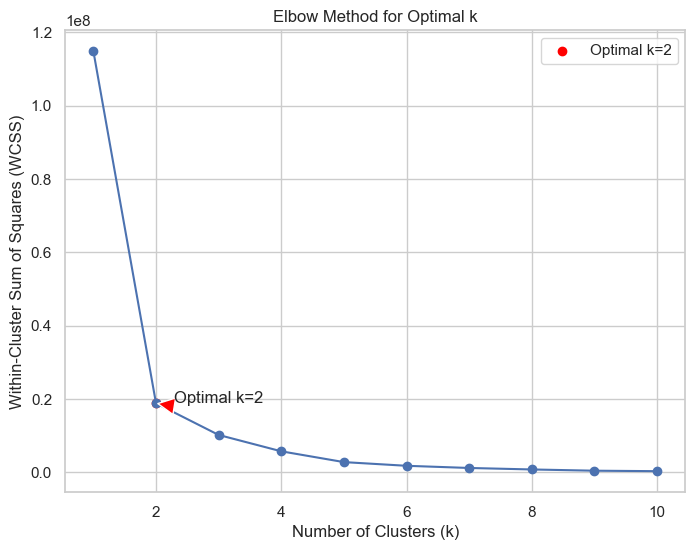

Optimal Number of Clusters (k): 2


In [271]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)


diff = np.diff(wcss)
k_optimal = np.argmin(diff) + 2 
optimal_wcss = wcss[k_optimal - 1]

# Plot the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.scatter(k_optimal, optimal_wcss, color='red', marker='o', label=f'Optimal k={k_optimal}')
plt.annotate(f'Optimal k={k_optimal}', xy=(k_optimal, optimal_wcss), xytext=(k_optimal + 1, optimal_wcss + 20000),
             arrowprops=dict(facecolor='red', shrink=0.1), fontsize=12, ha='center')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.legend()
plt.show()

print(f'Optimal Number of Clusters (k): {k_optimal}')


### Optimal clusters

In [272]:


def find_optimal_clusters(wcss):
    
    second_derivative = np.gradient(np.gradient(wcss))

  
    optimal_index = np.argmax(second_derivative) + 1

    return optimal_index

optimal_clusters = find_optimal_clusters(wcss)
print(f"The optimal number of clusters is: {optimal_clusters}")


The optimal number of clusters is: 2


### Cluster comparison plot

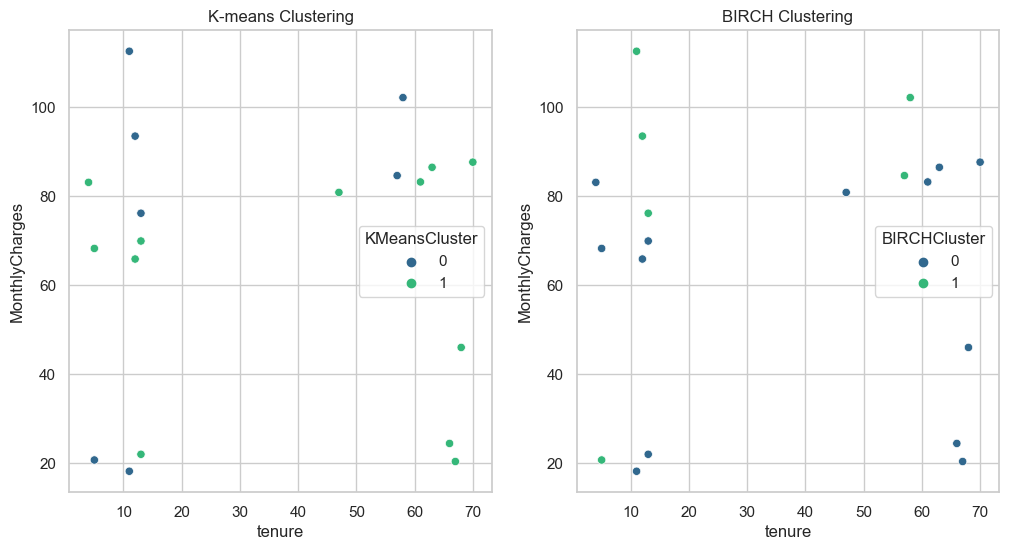

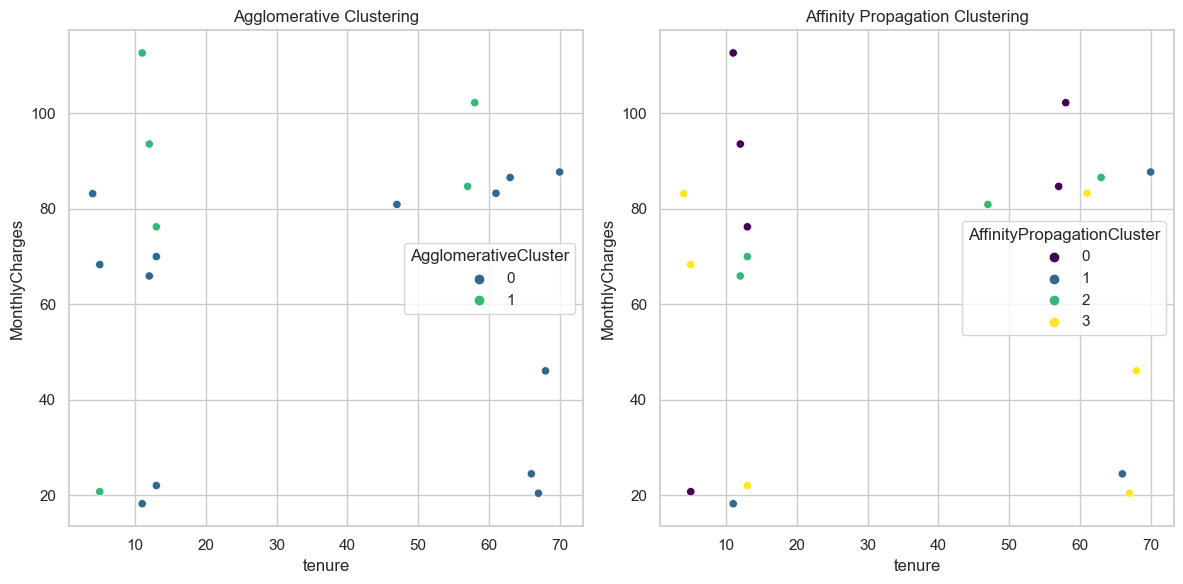

In [273]:
n_clusters = 2


kmeans = KMeans(n_clusters=n_clusters)
birch = Birch(n_clusters=n_clusters)


kmeans.fit(X)
birch.fit(X)

data['KMeansCluster'] = kmeans.labels_
data['BIRCHCluster'] = birch.labels_


sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='tenure', y='MonthlyCharges', hue='KMeansCluster', palette='viridis')
plt.title('K-means Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x='tenure', y='MonthlyCharges', hue='BIRCHCluster', palette='viridis')
plt.title('BIRCH Clustering')
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
affinity_propagation = AffinityPropagation()

agglomerative.fit(X)
affinity_propagation.fit(X)

data['AgglomerativeCluster'] = agglomerative.labels_
data['AffinityPropagationCluster'] = affinity_propagation.labels_

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='tenure', y='MonthlyCharges', hue='AgglomerativeCluster', palette='viridis')
plt.title('Agglomerative Clustering')

plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x='tenure', y='MonthlyCharges', hue='AffinityPropagationCluster', palette='viridis')
plt.title('Affinity Propagation Clustering')

plt.tight_layout()
plt.show()



### K-means

In [274]:

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

kmeans_inertia = 0.0
kmeans_silhouette = 0.0
kmeans_db_index = 0.0
kmeans_calinski_harabasz = 0.0

for cluster_id in range(n_clusters):
    cluster_points = X[kmeans_labels == cluster_id]
    cluster_center = kmeans.cluster_centers_[cluster_id]
    

    cluster_inertia = np.sum(np.square(np.linalg.norm(cluster_points - cluster_center, axis=1)))
    kmeans_inertia += cluster_inertia
    
 
    silhouette_cluster = silhouette_score(X, kmeans_labels)
    kmeans_silhouette += silhouette_cluster
    
 
    kmeans_db_index += davies_bouldin_score(X, kmeans_labels)
    

    kmeans_calinski_harabasz += calinski_harabasz_score(X, kmeans_labels)

kmeans_inertia /= n_clusters
kmeans_silhouette /= n_clusters
kmeans_db_index /= n_clusters
kmeans_calinski_harabasz /= n_clusters

### BIRCH

In [275]:
birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(X)

birch_inertia = 0.0
birch_silhouette = 0.0
birch_db_index = 0.0
birch_calinski_harabasz = 0.0

for cluster_id in range(n_clusters):
    cluster_points = X[birch_labels == cluster_id]
    cluster_center = birch.subcluster_centers_[cluster_id]
    
    cluster_inertia = np.sum(np.square(np.linalg.norm(cluster_points - cluster_center, axis=1)))
    birch_inertia += cluster_inertia
    
    silhouette_cluster = silhouette_score(X, birch_labels)
    birch_silhouette += silhouette_cluster
    
    birch_db_index += davies_bouldin_score(X, birch_labels)
    
    birch_calinski_harabasz += calinski_harabasz_score(X, birch_labels)

birch_inertia /= n_clusters
birch_silhouette /= n_clusters
birch_db_index /= n_clusters
birch_calinski_harabasz /= n_clusters


### Agglomerative Clustering

In [276]:


agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative_labels = agglomerative.fit_predict(X)

agglomerative_inertia = 0.0
agglomerative_silhouette = 0.0
agglomerative_db_index = 0.0
agglomerative_calinski_harabasz = 0.0

for cluster_id in range(n_clusters):
    cluster_points = X[agglomerative_labels == cluster_id]
    
 
    cluster_center = np.mean(cluster_points, axis=0)
    
    cluster_inertia = np.sum(np.square(np.linalg.norm(cluster_points - cluster_center, axis=1)))
    agglomerative_inertia += cluster_inertia
    
    silhouette_cluster = silhouette_score(X, agglomerative_labels)
    agglomerative_silhouette += silhouette_cluster
    
    agglomerative_db_index += davies_bouldin_score(X, agglomerative_labels)
    
    agglomerative_calinski_harabasz += calinski_harabasz_score(X, agglomerative_labels)

agglomerative_inertia /= n_clusters
agglomerative_silhouette /= n_clusters
agglomerative_db_index /= n_clusters
agglomerative_calinski_harabasz /= n_clusters




### Affinity Propagation

In [277]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


affinity_propagation = AffinityPropagation()
affinity_propagation_labels = affinity_propagation.fit_predict(X)

affinity_propagation_silhouette = silhouette_score(X, affinity_propagation_labels)

affinity_propagation_db_index = davies_bouldin_score(X, affinity_propagation_labels)

affinity_propagation_calinski_harabasz = calinski_harabasz_score(X, affinity_propagation_labels)




### Cluster comparison score

In [278]:
import pandas as pd


data = {
    'Technique': ['K-means', 'BIRCH', 'Agglomerative', 'Affinity Propagation'],
    'Inertia': [kmeans_inertia, birch_inertia, agglomerative_inertia, None],  # Affinity Propagation doesn't have Inertia
    'Silhouette Score': [kmeans_silhouette, birch_silhouette, agglomerative_silhouette, affinity_propagation_silhouette],
    'Davies-Bouldin Index': [kmeans_db_index, birch_db_index, agglomerative_db_index, affinity_propagation_db_index],
    'Calinski-Harabasz Index': [kmeans_calinski_harabasz, birch_calinski_harabasz, agglomerative_calinski_harabasz, affinity_propagation_calinski_harabasz]
}

comparison_df = pd.DataFrame(data)

print(comparison_df)


              Technique       Inertia  Silhouette Score  Davies-Bouldin Index  \
0               K-means  9.429950e+06          0.708295              0.350098   
1                 BIRCH  8.823455e+07          0.702302              0.320697   
2         Agglomerative  1.038020e+07          0.702302              0.320697   
3  Affinity Propagation           NaN          0.546830              0.453791   

   Calinski-Harabasz Index  
0                86.547403  
1                77.068206  
2                77.068206  
3                87.004528  


### Cluster comparison graph

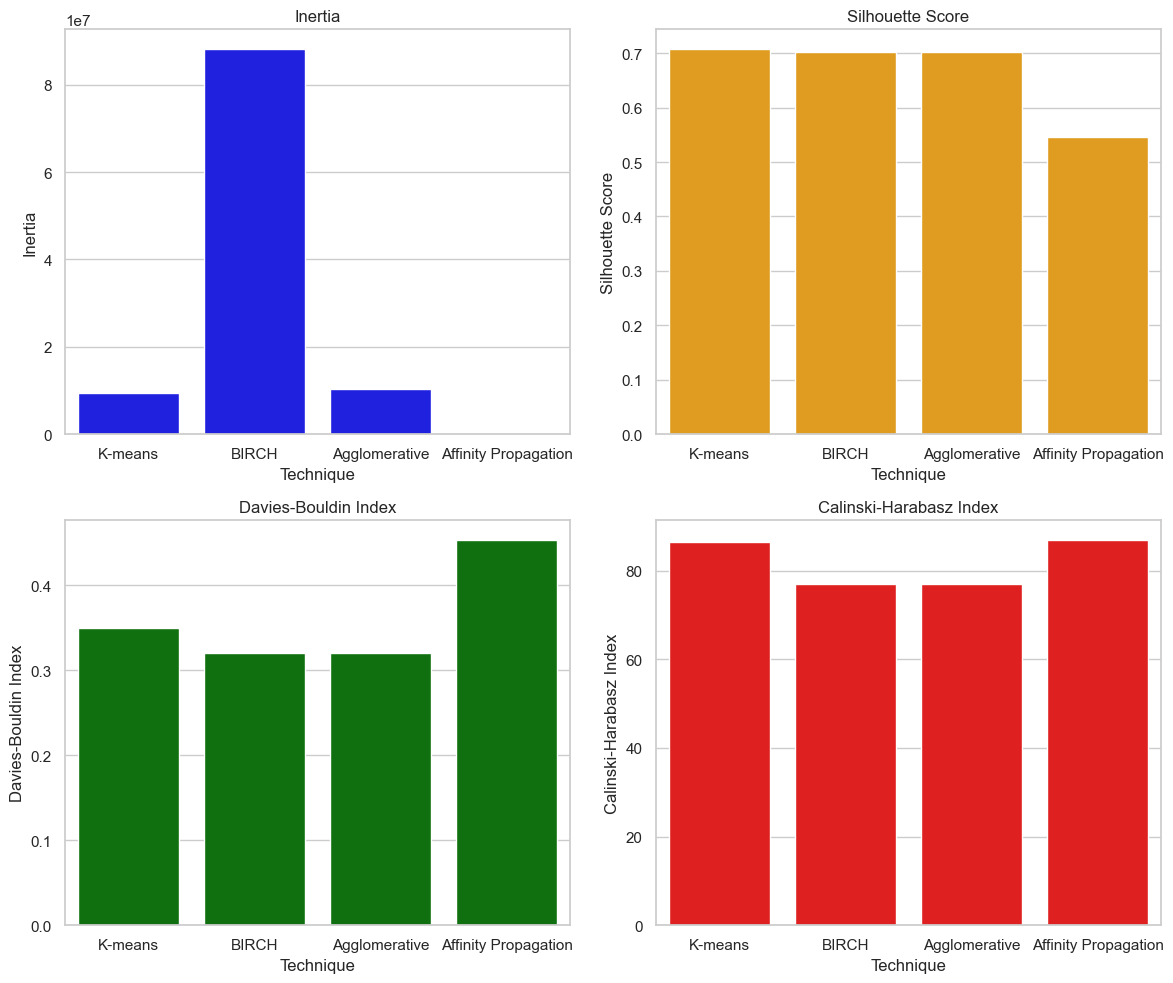

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))


sns.barplot(x='Technique', y='Inertia', data=comparison_df, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Inertia')


sns.barplot(x='Technique', y='Silhouette Score', data=comparison_df, ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Silhouette Score')


sns.barplot(x='Technique', y='Davies-Bouldin Index', data=comparison_df, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Davies-Bouldin Index')


sns.barplot(x='Technique', y='Calinski-Harabasz Index', data=comparison_df, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Calinski-Harabasz Index')


plt.tight_layout()


plt.show()

### Overall Score

In [280]:

data = {
    'Technique': ['K-means', 'BIRCH', 'Agglomerative', 'Affinity Propagation'],
    'Inertia': [kmeans_inertia, birch_inertia, agglomerative_inertia, None],  # Affinity Propagation doesn't have Inertia
    'Silhouette Score': [kmeans_silhouette, birch_silhouette, agglomerative_silhouette, affinity_propagation_silhouette],
    'Davies-Bouldin Index': [kmeans_db_index, birch_db_index, agglomerative_db_index, affinity_propagation_db_index],
    'Calinski-Harabasz Index': [kmeans_calinski_harabasz, birch_calinski_harabasz, agglomerative_calinski_harabasz, affinity_propagation_calinski_harabasz]
}

comparison_df = pd.DataFrame(data)


scaler = StandardScaler()
scaled_metrics = scaler.fit_transform(comparison_df.iloc[:, 1:])
overall_score = scaled_metrics.mean(axis=1)


comparison_df['Overall Score'] = overall_score


print(comparison_df[['Technique', 'Overall Score']])


              Technique  Overall Score
0               K-means       0.165724
1                 BIRCH       0.055000
2         Agglomerative      -0.472084
3  Affinity Propagation            NaN


### Best Clustering Technique

In [281]:



best_technique = comparison_df.loc[comparison_df['Overall Score'].idxmax()]


print("Best Clustering Technique:")
print(best_technique[['Technique', 'Overall Score']])


Best Clustering Technique:
Technique         K-means
Overall Score    0.165724
Name: 0, dtype: object


### comparison graph

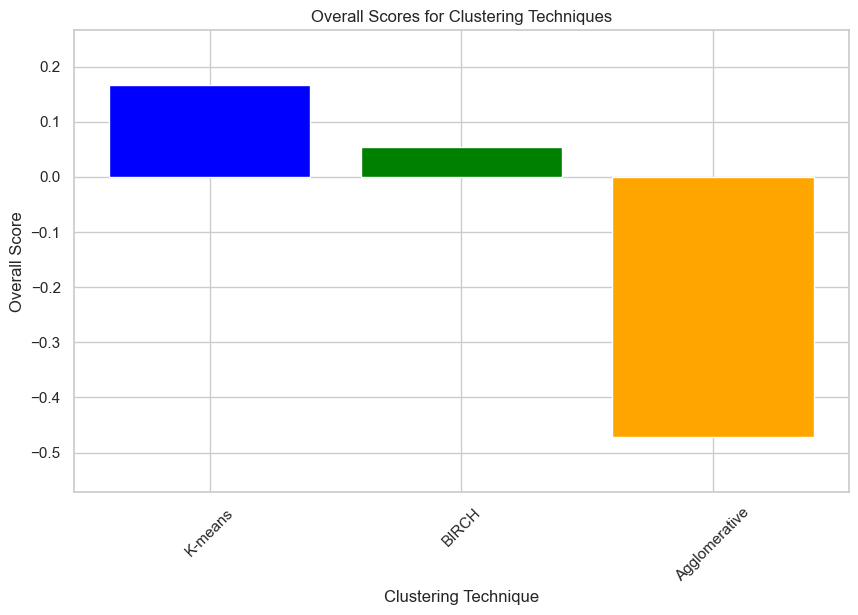

In [282]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Technique'], comparison_df['Overall Score'], color=['blue', 'green', 'orange', 'red'])
plt.title('Overall Scores for Clustering Techniques')
plt.xlabel('Clustering Technique')
plt.ylabel('Overall Score')
plt.ylim(min(comparison_df['Overall Score']) - 0.1, max(comparison_df['Overall Score']) + 0.1)
plt.xticks(rotation=45)
plt.show()


### 3D comparison

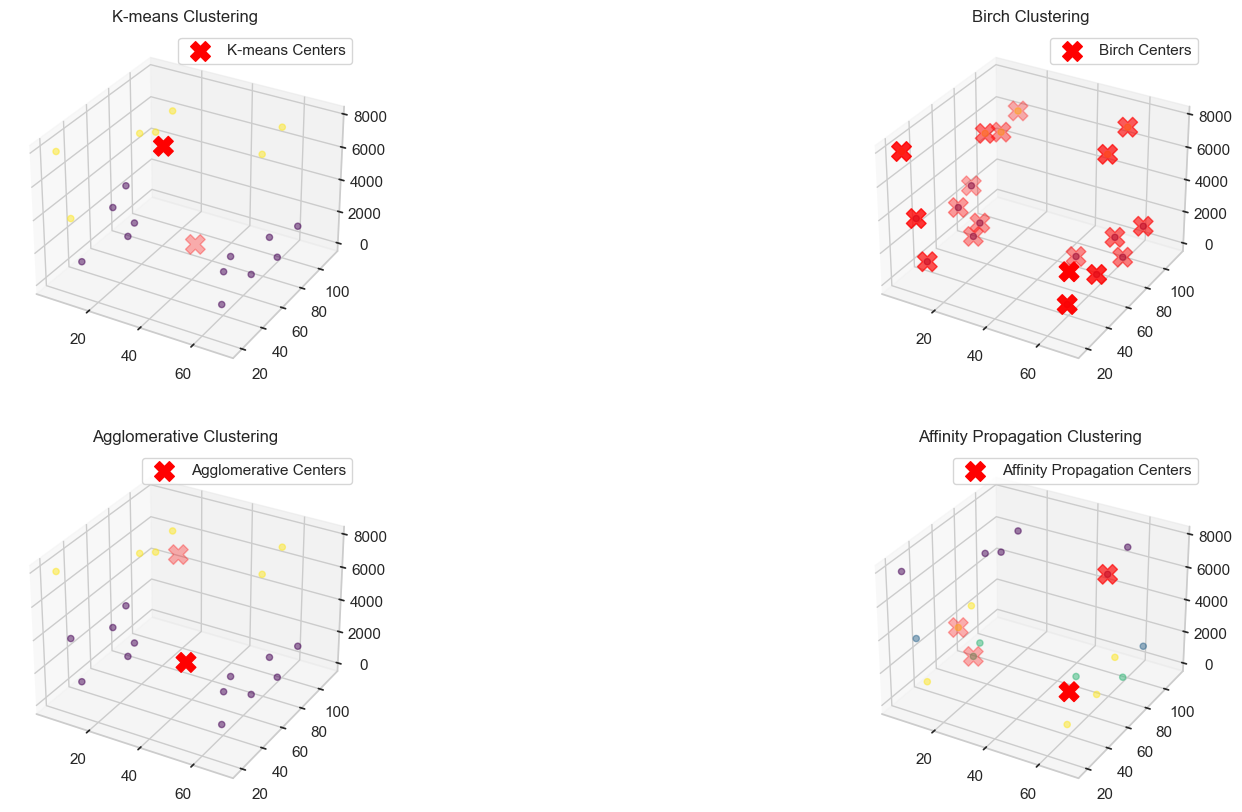

In [283]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, AffinityPropagation
from sklearn.datasets import make_blobs


X = X.values if isinstance(X, pd.DataFrame) else X


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
kmeans_centers = kmeans.cluster_centers_


birch = Birch(n_clusters=n_clusters)
birch.fit(X)
birch_labels = birch.predict(X)
birch_centers = birch.subcluster_centers_


agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative_labels = agglomerative.fit_predict(X)
agglomerative_centers = np.array([X[agglomerative_labels == i].mean(axis=0) for i in range(n_clusters)])


affinity_propagation = AffinityPropagation()
affinity_propagation_labels = affinity_propagation.fit_predict(X)
affinity_propagation_centers = X[affinity_propagation.cluster_centers_indices_]


fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.5)
ax1.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], kmeans_centers[:, 2], c='red', marker='X', s=200, label='K-means Centers')
ax1.set_title('K-means Clustering')
ax1.legend()


ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], X[:, 2], c=birch_labels, cmap='viridis', alpha=0.5)
ax2.scatter(birch_centers[:, 0], birch_centers[:, 1], birch_centers[:, 2], c='red', marker='X', s=200, label='Birch Centers')
ax2.set_title('Birch Clustering')
ax2.legend()


ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(X[:, 0], X[:, 1], X[:, 2], c=agglomerative_labels, cmap='viridis', alpha=0.5)
ax3.scatter(agglomerative_centers[:, 0], agglomerative_centers[:, 1], agglomerative_centers[:, 2], c='red', marker='X', s=200, label='Agglomerative Centers')
ax3.set_title('Agglomerative Clustering')
ax3.legend()

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(X[:, 0], X[:, 1], X[:, 2], c=affinity_propagation_labels, cmap='viridis', alpha=0.5)
ax4.scatter(affinity_propagation_centers[:, 0], affinity_propagation_centers[:, 1], affinity_propagation_centers[:, 2], c='red', marker='X', s=200, label='Affinity Propagation Centers')
ax4.set_title('Affinity Propagation Clustering')
ax4.legend()

plt.show()


### 2D comparison

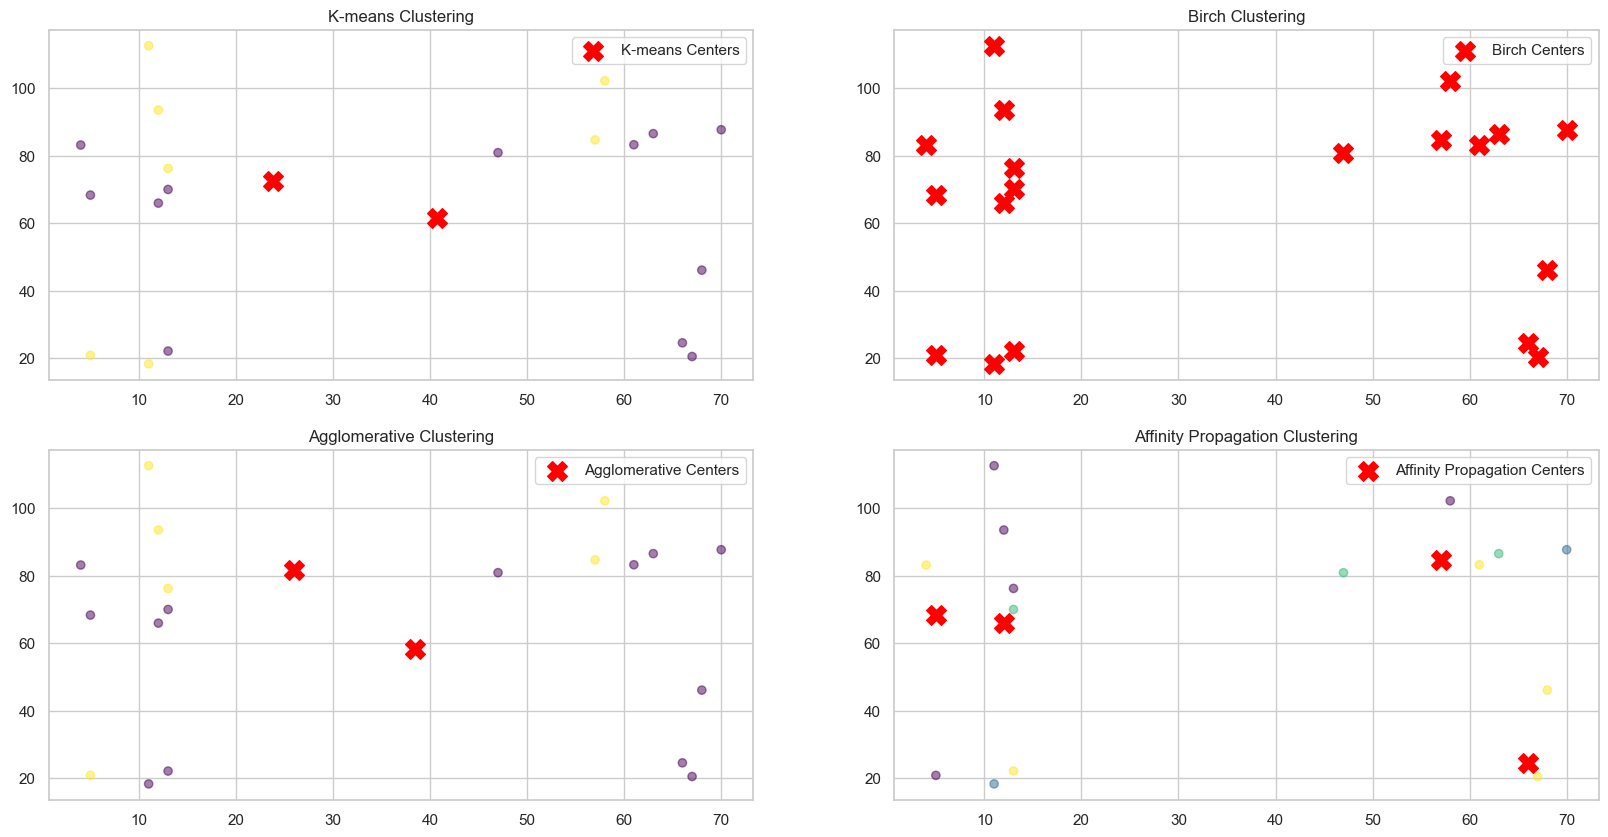

In [284]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, AffinityPropagation
from sklearn.datasets import make_blobs


X = X.values if isinstance(X, pd.DataFrame) else X


kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
kmeans_centers = kmeans.cluster_centers_


birch = Birch(n_clusters=n_clusters)
birch.fit(X)
birch_labels = birch.predict(X)
birch_centers = birch.subcluster_centers_


agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative_labels = agglomerative.fit_predict(X)
agglomerative_centers = np.array([X[agglomerative_labels == i].mean(axis=0) for i in range(n_clusters)])


affinity_propagation = AffinityPropagation()
affinity_propagation_labels = affinity_propagation.fit_predict(X)
affinity_propagation_centers = X[affinity_propagation.cluster_centers_indices_]

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
ax1.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', marker='X', s=200, label='K-means Centers')
ax1.set_title('K-means Clustering')
ax1.legend()


ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(X[:, 0], X[:, 1], c=birch_labels, cmap='viridis', alpha=0.5)
ax2.scatter(birch_centers[:, 0], birch_centers[:, 1], c='red', marker='X', s=200, label='Birch Centers')
ax2.set_title('Birch Clustering')
ax2.legend()


ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(X[:, 0], X[:, 1], c=agglomerative_labels, cmap='viridis', alpha=0.5)
ax3.scatter(agglomerative_centers[:, 0], agglomerative_centers[:, 1], c='red', marker='X', s=200, label='Agglomerative Centers')
ax3.set_title('Agglomerative Clustering')
ax3.legend()


ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(X[:, 0], X[:, 1], c=affinity_propagation_labels, cmap='viridis', alpha=0.5)
ax4.scatter(affinity_propagation_centers[:, 0], affinity_propagation_centers[:, 1], c='red', marker='X', s=200, label='Affinity Propagation Centers')
ax4.set_title('Affinity Propagation Clustering')
ax4.legend()

plt.show()


### Choosing best clustering technique

In [285]:

clustering_model = None
if best_cluster_technique['Technique'] == 'K-means':
    clustering_model = KMeans(n_clusters=n_clusters)
elif best_cluster_technique['Technique'] == 'BIRCH':
    clustering_model = Birch(n_clusters=n_clusters)
elif best_cluster_technique['Technique'] == 'Agglomerative':
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
elif best_cluster_technique['Technique'] == 'Affinity Propagation':
    clustering_model = AffinityPropagation()


cluster_labels = clustering_model.fit_predict(X)

### Training and Testing

In [286]:
X_train, X_test, y_train, y_test = train_test_split(cluster_labels.reshape(-1, 1), y, test_size=0.2, random_state=42)


### Logistic Regression

In [287]:

cluster_labels = clustering_model.fit_predict(X)


X_train, X_test, y_train, y_test = train_test_split(cluster_labels.reshape(-1, 1), y, test_size=0.2, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)


y_pred_logreg = logreg.predict(X_test)


accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Logistic Regression Accuracy with Best Clustering Technique:", accuracy_logreg)



Logistic Regression Accuracy with Best Clustering Technique: 0.75


In [288]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred_logreg)
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[3 0]
 [1 0]]
Classification Report:
               precision    recall  f1-score   support

          No       0.75      1.00      0.86         3
         Yes       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



### Random Forest

In [289]:


cluster_labels_train = clustering_model.fit_predict(X_train)
cluster_labels_test = clustering_model.predict(X_test)


X_train_df = pd.DataFrame(X_train, columns=[str(i) for i in range(X_train.shape[1])])
X_test_df = pd.DataFrame(X_test, columns=[str(i) for i in range(X_test.shape[1])])

X_train_with_clusters = pd.concat([X_train_df, pd.Series(cluster_labels_train, name='Cluster_Labels')], axis=1)
X_test_with_clusters = pd.concat([X_test_df, pd.Series(cluster_labels_test, name='Cluster_Labels')], axis=1)

random_forest = RandomForestClassifier()
random_forest.fit(X_train_with_clusters, y_train)


y_pred_rf = random_forest.predict(X_test_with_clusters)


accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy with Best Clustering Technique:", accuracy_rf)

Random Forest Accuracy with Best Clustering Technique: 0.0


In [290]:

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[0 3]
 [1 0]]
Classification Report:
               precision    recall  f1-score   support

          No       0.00      0.00      0.00       3.0
         Yes       0.00      0.00      0.00       1.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



### Decision Tree

In [291]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

decision_tree_reg = DecisionTreeRegressor()
decision_tree_reg.fit(X_train, y_train_encoded)


y_test_encoded = label_encoder.transform(y_test)

y_pred_dt_reg = decision_tree_reg.predict(X_test)


mse_dt_reg = mean_squared_error(y_test_encoded, y_pred_dt_reg)
print("Mean Squared Error for Decision Tree Regression with Best Clustering Technique:", mse_dt_reg)



Mean Squared Error for Decision Tree Regression with Best Clustering Technique: 0.34750000000000003


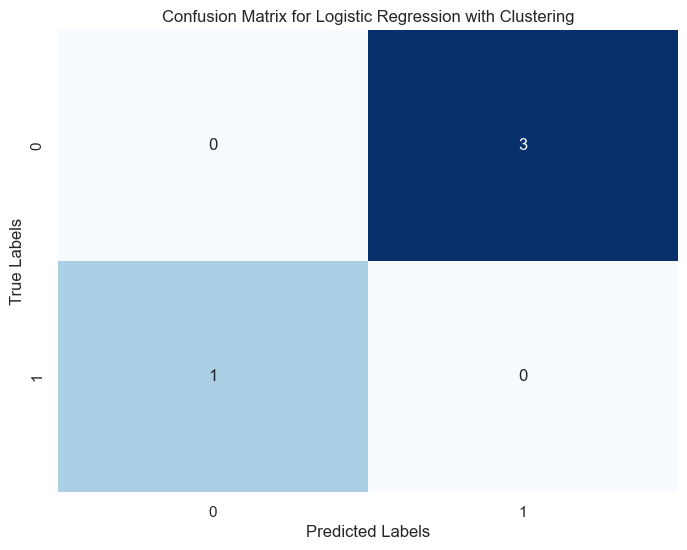

In [292]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression with Clustering')
plt.show()
